<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Python for Algorithmic Trading

**Chapter 10 &mdash; Automating Trading Operations**

## Risk Disclaimer

<font size="-1">
Trading forex/CFDs on margin carries a high level of risk and may not be suitable for all investors as you could sustain losses in excess of deposits. Leverage can work against you. Due to the certain restrictions imposed by the local law and regulation, German resident retail client(s) could sustain a total loss of deposited funds but are not subject to subsequent payment obligations beyond the deposited funds. Be aware and fully understand all risks associated with the market and trading. Prior to trading any products, carefully consider your financial situation and experience level. Any opinions, news, research, analyses, prices, or other information is provided as general market commentary, and does not constitute investment advice. Oanda & TPQ will not accept liability for any loss or damage, including without limitation to, any loss of profit, which may arise directly or indirectly from use of or reliance on such information.
</font>

## Author Disclaimer

<font size="-1">
The author is neither an employee, agent nor representative of Oanda and is therefore acting independently. The opinions given are their own, constitute general market commentary, and do not constitute the opinion or advice of Oanda or any form of personal or investment advice. Oanda assumes no responsibility for any loss or damage, including but not limited to, any loss or gain arising out of the direct or indirect use of this or any other content. Trading forex/CFDs on margin carries a high level of risk and may not be suitable for all investors as you could sustain losses in excess of deposits.
</font>

In [1]:
import math
import time
import numpy as np
import pandas as pd
import datetime as dt
from pylab import plt, mpl

In [2]:
np.random.seed(1000)
plt.style.use('seaborn-v0_8')
mpl.rcParams['font.family'] = 'serif'

In [3]:
import warnings
warnings.simplefilter('ignore')

## Capital Management

### Kelly Criterion in a Binomial Setting

In [4]:
p = 0.55

In [5]:
f = p - (1 - p)

In [6]:
f

0.10000000000000009

In [7]:
I = 50

In [8]:
n = 100

In [9]:
def run_simulation(f):
    c = np.zeros((n, I))
    c[0] = 100
    for i in range(I):
        for t in range(1, n):
            o = np.random.binomial(1, p)
            if o > 0:
                c[t, i] = (1 + f) * c[t - 1, i]
            else:
                c[t, i] = (1 - f) * c[t - 1, i]
    return c

In [10]:
c_1 = run_simulation(f)

In [11]:
c_1.round(2)

array([[100.  , 100.  , 100.  , ..., 100.  , 100.  , 100.  ],
       [ 90.  , 110.  ,  90.  , ..., 110.  ,  90.  , 110.  ],
       [ 99.  , 121.  ,  99.  , ..., 121.  ,  81.  , 121.  ],
       ...,
       [226.35, 338.13, 413.27, ..., 123.97, 123.97, 123.97],
       [248.99, 371.94, 454.6 , ..., 136.37, 136.37, 136.37],
       [273.89, 409.14, 409.14, ..., 122.73, 150.01, 122.73]])

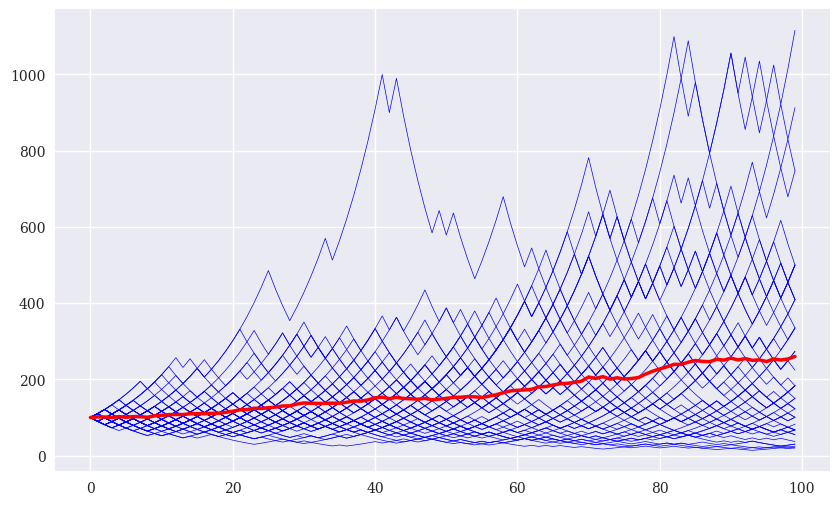

In [12]:
plt.figure(figsize=(10, 6))
plt.plot(c_1, 'b', lw=0.5)
plt.plot(c_1.mean(axis=1), 'r', lw=2.5);

In [13]:
c_2 = run_simulation(0.05)

In [14]:
c_3 = run_simulation(0.25)

In [15]:
c_4 = run_simulation(0.5)

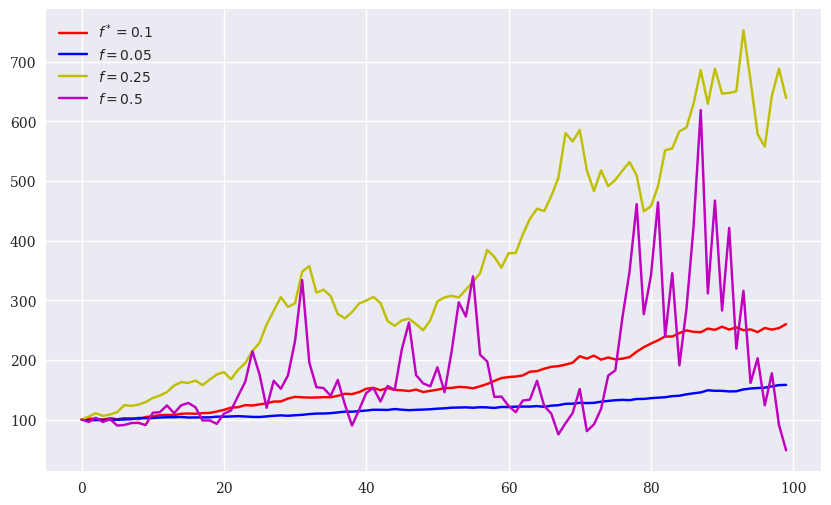

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(c_1.mean(axis=1), 'r', label='$f^*=0.1$')
plt.plot(c_2.mean(axis=1), 'b', label='$f=0.05$')
plt.plot(c_3.mean(axis=1), 'y', label='$f=0.25$')
plt.plot(c_4.mean(axis=1), 'm', label='$f=0.5$')
plt.legend(loc=0);

### Kelly Criterion for Stocks and Indices

In [17]:
raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                  index_col=0, parse_dates=True)

In [18]:
symbol = '.SPX'

In [19]:
data = pd.DataFrame(raw[symbol])

In [20]:
data['return'] = np.log(data / data.shift(1))

In [21]:
data.dropna(inplace=True)

In [22]:
data.tail()

,.SPX,return
Date,,
2019-12-23,3224.01,0.000866
2019-12-24,3223.38,-0.000195
2019-12-27,3240.02,0.000034
2019-12-30,3221.29,-0.005798
2019-12-31,3230.78,0.002942


In [23]:
mu = data['return'].mean() * 252

In [24]:
mu

0.09992181916534204

In [25]:
sigma = data['return'].std() * 252 ** 0.5

In [26]:
sigma

0.14761569775486563

In [27]:
r = 0.0

In [28]:
f = (mu - r) / sigma ** 2 # <5>

In [29]:
f

4.585590244019818

In [30]:
equs = []

In [31]:
def kelly_strategy(f):
    global equs
    equ = 'equity_{:.2f}'.format(f)
    equs.append(equ)
    cap = 'capital_{:.2f}'.format(f)
    data[equ] = 1
    data[cap] = data[equ] * f
    for i, t in enumerate(data.index[1:]):
        t_1 = data.index[i]
        data.loc[t, cap] = data[cap].loc[t_1] * \
                            math.exp(data['return'].loc[t])
        data.loc[t, equ] = data[cap].loc[t] - \
                            data[cap].loc[t_1] + \
                            data[equ].loc[t_1]
        data.loc[t, cap] = data[equ].loc[t] * f

In [32]:
kelly_strategy(f * 0.5)

In [33]:
kelly_strategy(f * 0.66)

In [34]:
kelly_strategy(f)

In [35]:
print(data[equs].tail())

            equity_2.29  equity_3.03  equity_4.59
Date                                             
2019-12-23     6.628865     9.585294    14.205748
2019-12-24     6.625895     9.579626    14.193019
2019-12-27     6.626410     9.580610    14.195229
2019-12-30     6.538582     9.412991    13.818934
2019-12-31     6.582748     9.496919    14.005618


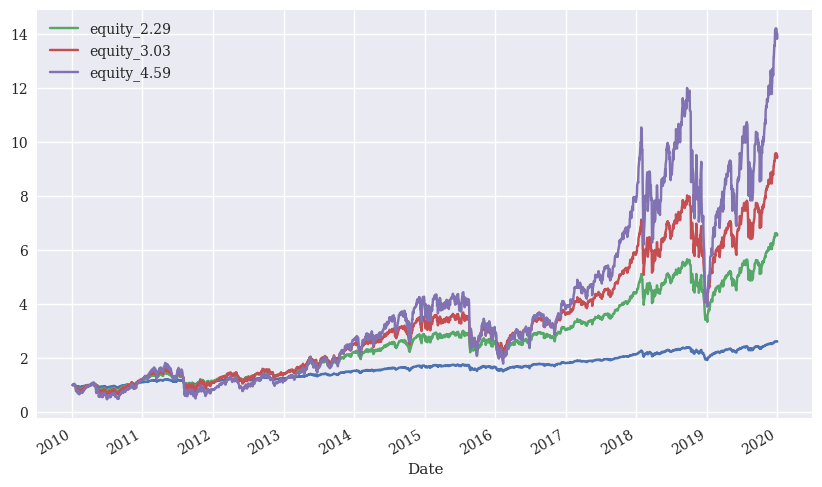

In [36]:
ax = data['return'].cumsum().apply(np.exp).plot(figsize=(10, 6))
data[equs].plot(ax=ax, legend=True);

## ML-Based Trading Strategy

### Vectorized Backtesting

In [37]:
import tpqoa

In [38]:
%time api = tpqoa.tpqoa('../../pyalgo.cfg')

CPU times: user 1.11 ms, sys: 402 µs, total: 1.51 ms
Wall time: 3.29 ms


In [39]:
instrument = 'EUR_USD'

In [40]:
raw = api.get_history(instrument,
                       start='2020-06-08',
                       end='2020-06-13',
                       granularity='M10',
                       price='M')

In [41]:
raw.tail()

,o,h,l,c,volume,complete
time,,,,,,
2020-06-12 20:10:00,1.12572,1.12593,1.12532,1.12568,221,True
2020-06-12 20:20:00,1.12569,1.12578,1.12532,1.12558,163,True
2020-06-12 20:30:00,1.12560,1.12573,1.12534,1.12543,192,True
2020-06-12 20:40:00,1.12544,1.12594,1.12528,1.12542,219,True
2020-06-12 20:50:00,1.12544,1.12624,1.12541,1.12554,296,True


In [42]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 701 entries, 2020-06-08 00:00:00 to 2020-06-12 20:50:00
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   o         701 non-null    float64
 1   h         701 non-null    float64
 2   l         701 non-null    float64
 3   c         701 non-null    float64
 4   volume    701 non-null    int64  
 5   complete  701 non-null    bool   
dtypes: bool(1), float64(4), int64(1)
memory usage: 33.5 KB


In [43]:
spread = 0.00012

In [44]:
mean = raw['c'].mean()

In [45]:
ptc = spread / mean
ptc

0.00010599557439495706

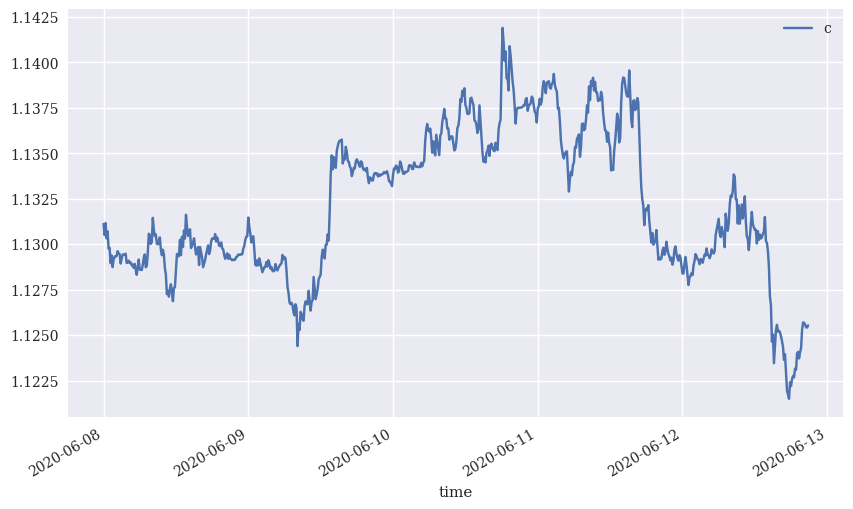

In [46]:
raw['c'].plot(figsize=(10, 6), legend=True);

In [47]:
data = pd.DataFrame(raw['c'])

In [48]:
data.columns = [instrument,]

In [49]:
window = 20
data['return'] = np.log(data / data.shift(1))
data['vol'] = data['return'].rolling(window).std()
data['mom'] = np.sign(data['return'].rolling(window).mean())
data['sma'] = data[instrument].rolling(window).mean()
data['min'] = data[instrument].rolling(window).min()
data['max'] = data[instrument].rolling(window).max()

In [50]:
data.dropna(inplace=True)

In [51]:
lags = 6

In [52]:
features = ['return', 'vol', 'mom', 'sma', 'min', 'max']

In [53]:
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = f'{f}_lag_{lag}'
        data[col] = data[f].shift(lag)
        cols.append(col)

In [54]:
data.dropna(inplace=True)

In [55]:
data['direction'] = np.where(data['return'] > 0, 1, -1)

In [56]:
data[cols].iloc[:lags, :lags]

,return_lag_1,return_lag_2,return_lag_3,return_lag_4,return_lag_5,return_lag_6
time,,,,,,
2020-06-08 04:20:00,0.000097,0.000018,-0.000452,0.000035,0.000000,0.000009
2020-06-08 04:30:00,-0.000115,0.000097,0.000018,-0.000452,0.000035,0.000000
2020-06-08 04:40:00,0.000027,-0.000115,0.000097,0.000018,-0.000452,0.000035
2020-06-08 04:50:00,-0.000142,0.000027,-0.000115,0.000097,0.000018,-0.000452
2020-06-08 05:00:00,0.000035,-0.000142,0.000027,-0.000115,0.000097,0.000018
2020-06-08 05:10:00,-0.000159,0.000035,-0.000142,0.000027,-0.000115,0.000097


In [57]:
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

In [58]:
n_estimators=15
random_state=100
max_depth=2
min_samples_leaf=15
subsample=0.33

In [59]:
dtc = DecisionTreeClassifier(random_state=random_state,
                             max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf)

In [60]:
model = AdaBoostClassifier(base_estimator=dtc,
                          n_estimators=n_estimators,
                          random_state=random_state)

In [61]:
split = int(len(data) * 0.7)

In [62]:
train = data.iloc[:split].copy()

In [63]:
mu, std = train.mean(), train.std()

In [64]:
train_ = (train - mu) / std

In [65]:
model.fit(train_[cols], train['direction'])

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [66]:
accuracy_score(train['direction'], model.predict(train_[cols]))

0.8050847457627118

In [67]:
test = data.iloc[split:].copy()

In [68]:
test_ = (test - mu) / std

In [69]:
test['position'] = model.predict(test_[cols])

In [70]:
accuracy_score(test['direction'], test['position'])

0.5665024630541872

In [71]:
test['strategy'] = test['position'] * test['return']

In [72]:
sum(test['position'].diff() != 0)

77

In [73]:
test['strategy_tc'] = np.where(test['position'].diff() != 0,
                               test['strategy'] - ptc,
                               test['strategy'])

In [74]:
test[['return', 'strategy', 'strategy_tc']].sum(
        ).apply(np.exp)

return         0.990182
strategy       1.015827
strategy_tc    1.007570
dtype: float64

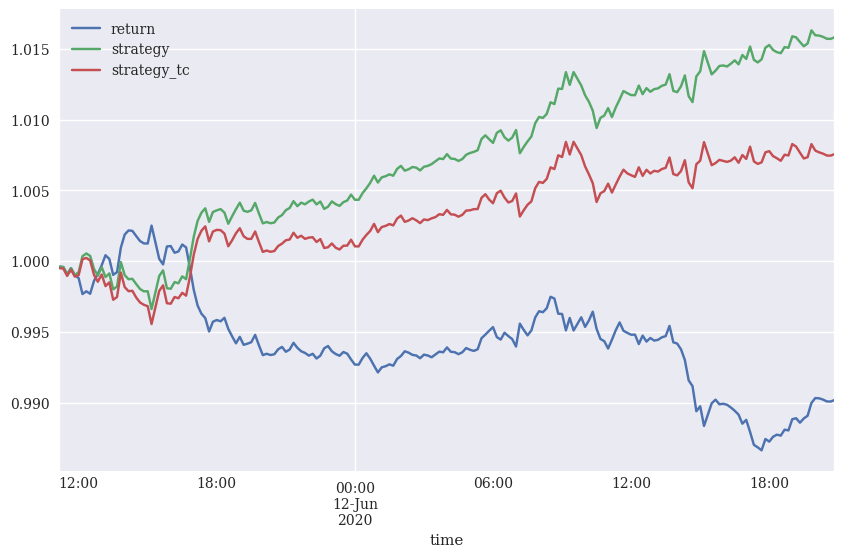

In [75]:
test[['return', 'strategy', 'strategy_tc']].cumsum(
        ).apply(np.exp).plot(figsize=(10, 6));

In [76]:
mean = test[['return', 'strategy_tc']].mean() * len(data) * 52
mean

return        -1.705965
strategy_tc    1.304023
dtype: float64

In [77]:
var = test[['return', 'strategy_tc']].var() * len(data) * 52
var

return         0.011306
strategy_tc    0.011370
dtype: float64

In [78]:
vol = var ** 0.5
vol

return         0.106332
strategy_tc    0.106631
dtype: float64

In [79]:
mean / var

return        -150.884961
strategy_tc    114.687875
dtype: float64

In [80]:
mean / var * 0.5

return        -75.442481
strategy_tc    57.343938
dtype: float64

In [81]:
to_plot = ['return', 'strategy_tc']  

In [82]:
for lev in [10, 20, 30, 40, 50]:  
    label = 'lstrategy_tc_%d' % lev  
    test[label] = test['strategy_tc'] * lev
    to_plot.append(label)  

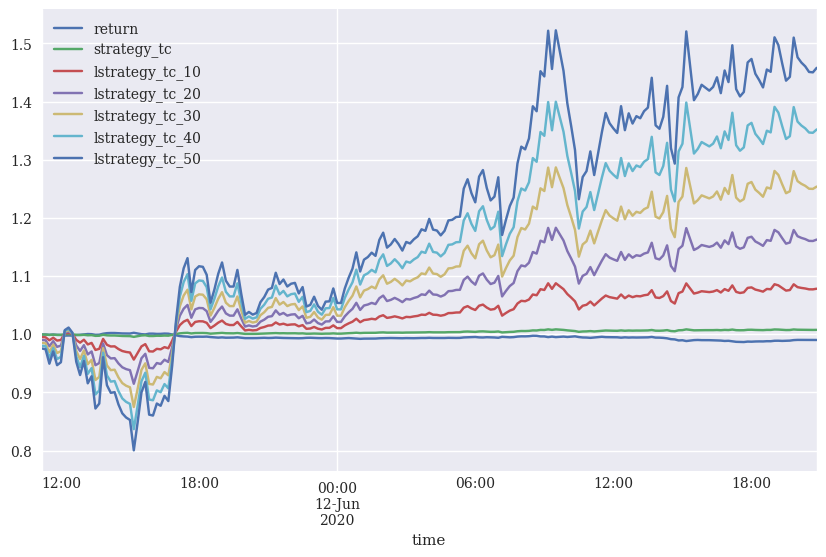

In [83]:
test[to_plot].cumsum().apply(np.exp).plot(figsize=(10, 6));

### Risk Analysis

In [84]:
equity = 3333

In [85]:
risk = pd.DataFrame(test['lstrategy_tc_30'])

In [86]:
risk['equity'] = risk['lstrategy_tc_30'].cumsum(
                          ).apply(np.exp) * equity

In [87]:
risk['cummax'] = risk['equity'].cummax()

In [88]:
risk['drawdown'] = risk['cummax'] - risk['equity']

In [89]:
risk['drawdown'].max()

511.38321383258017

In [90]:
t_max = risk['drawdown'].idxmax()
t_max

Timestamp('2020-06-12 10:30:00')

In [91]:
temp = risk['drawdown'][risk['drawdown'] == 0]

In [92]:
periods = (temp.index[1:].to_pydatetime() -
           temp.index[:-1].to_pydatetime())

In [93]:
periods[20:30]

array([datetime.timedelta(seconds=600), datetime.timedelta(seconds=1200),
       datetime.timedelta(seconds=1200), datetime.timedelta(seconds=1200)],
      dtype=object)

In [94]:
t_per = periods.max()

In [95]:
t_per

datetime.timedelta(seconds=26400)

In [96]:
t_per.seconds / 60 / 60

7.333333333333333

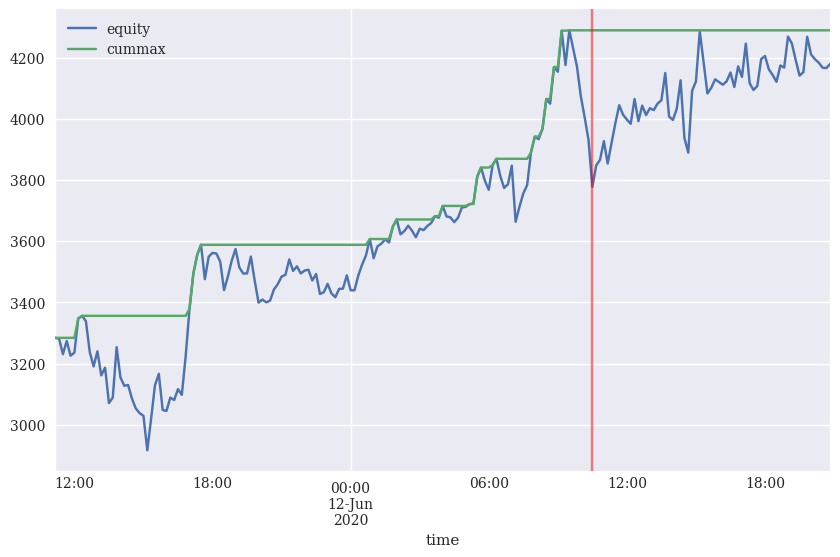

In [99]:
risk[['equity', 'cummax']].plot(figsize=(10, 6))
plt.axvline(t_max, c='r', alpha=0.5);

In [100]:
import scipy.stats as scs

In [101]:
percs = [0.01, 0.1, 1., 2.5, 5.0, 10.0]

In [102]:
risk['return'] = np.log(risk['equity'] /
                         risk['equity'].shift(1))

In [103]:
VaR = scs.scoreatpercentile(equity * risk['return'], percs)

In [104]:
def print_var():
    print('{}    {}'.format('Confidence Level', 'Value-at-Risk'))
    print(33 * '-')
    for pair in zip(percs, VaR):
        print('{:16.2f} {:16.3f}'.format(100 - pair[0], -pair[1])) 

In [105]:
print_var()

Confidence Level    Value-at-Risk
---------------------------------
           99.99          162.570
           99.90          161.348
           99.00          132.382
           97.50          122.913
           95.00          100.950
           90.00           62.622


In [106]:
hourly = risk.resample('1H', label='right').last()

In [107]:
hourly['return'] = np.log(hourly['equity'] /
                         hourly['equity'].shift(1))

In [108]:
VaR = scs.scoreatpercentile(equity * hourly['return'], percs)

In [109]:
print_var()

Confidence Level    Value-at-Risk
---------------------------------
           99.99          252.460
           99.90          251.744
           99.00          244.593
           97.50          232.674
           95.00          125.498
           90.00           61.701


### Persisting the Model Object

In [110]:
import pickle

In [111]:
algorithm = {'model': model, 'mu': mu, 'std': std}

In [112]:
pickle.dump(algorithm, open('algorithm.pkl', 'wb'))

## Online Algorithm

In [113]:
algorithm = pickle.load(open('algorithm.pkl', 'rb'))

In [114]:
algorithm['model']

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2,
                                                         min_samples_leaf=15,
                                                         random_state=100),
                   n_estimators=15, random_state=100)

In [115]:
class MLTrader(tpqoa.tpqoa):
    def __init__(self, config_file, algorithm):
        super(MLTrader, self).__init__(config_file)
        self.model = algorithm['model']
        self.mu = algorithm['mu']
        self.std = algorithm['std']
        self.units = 100000
        self.position = 0
        self.bar = '5s'
        self.window = 2
        self.lags = 6
        self.min_length = self.lags + self.window + 1
        self.features = ['return', 'vol', 'mom', 'sma', 'min', 'max']
        self.raw_data = pd.DataFrame()
    def prepare_features(self):
        self.data['return'] = np.log(self.data['mid'] /
                                     self.data['mid'].shift(1))
        self.data['vol'] = self.data['return'].rolling(
            self.window).std()
        self.data['mom'] = np.sign(
            self.data['return'].rolling(self.window).mean())
        self.data['sma'] = self.data['mid'].rolling(self.window).mean()
        self.data['min'] = self.data['mid'].rolling(self.window).min()
        self.data['max'] = self.data['mid'].rolling(self.window).max()
        self.data.dropna(inplace=True)
        self.data[self.features] -= self.mu
        self.data[self.features] /= self.std
        self.cols = []
        for f in self.features:
            for lag in range(1, self.lags + 1):
                col = f'{f}_lag_{lag}'
                self.data[col] = self.data[f].shift(lag)
                self.cols.append(col)
    def on_success(self, time, bid, ask):
        # print(self.ticks, 20 * ' ', end='\r')
        df = pd.DataFrame({'bid': float(bid), 'ask': float(ask)},
                         index=[pd.Timestamp(time).tz_localize(None)])
        self.raw_data = pd.concat((self.raw_data, df))
        self.data = self.raw_data.resample(self.bar,
                                label='right').last().ffill()
        self.data = self.data.iloc[:-1]
        if len(self.data) > self.min_length:
            self.min_length +=1
            self.data['mid'] = (self.data['bid'] +
                                self.data['ask']) / 2
            self.prepare_features()
            features = self.data[
                self.cols].iloc[-1].values.reshape(1, -1)
            signal = self.model.predict(features)[0]
            print(f'NEW SIGNAL: {signal}', end='\r')
            if self.position in [0, -1] and signal == 1:
                print('*** GOING LONG ***')
                self.create_order(self.stream_instrument,
                            units=(1 - self.position) * self.units)
                self.position = 1
            elif self.position in [0, 1] and signal == -1:
                print('*** GOING SHORT ***')
                self.create_order(self.stream_instrument,
                            units=-(1 + self.position) * self.units)
                self.position = -1

In [117]:
mlt = MLTrader('../../pyalgo.cfg', algorithm)

In [118]:
mlt.stream_data(instrument, stop=250)
print('*** CLOSING OUT ***')
mlt.create_order(mlt.stream_instrument,
                  units=-mlt.position * mlt.units)

*** GOING LONG ***


 {'id': '3780', 'time': '2023-10-09T14:48:15.551122281Z', 'userID': 13834683, 'accountID': '101-004-13834683-001', 'batchID': '3779', 'requestID': '61160354357600130', 'type': 'ORDER_FILL', 'orderID': '3779', 'instrument': 'EUR_USD', 'units': '100000.0', 'gainQuoteHomeConversionFactor': '0.943499106314', 'lossQuoteHomeConversionFactor': '0.952981509393', 'price': 1.05466, 'fullVWAP': 1.05466, 'fullPrice': {'type': 'PRICE', 'bids': [{'price': 1.05451, 'liquidity': '10000000'}], 'asks': [{'price': 1.05466, 'liquidity': '10000000'}], 'closeoutBid': 1.05451, 'closeoutAsk': 1.05466}, 'reason': 'MARKET_ORDER', 'pl': '0.0', 'financing': '0.0', 'commission': '0.0', 'guaranteedExecutionFee': '0.0', 'accountBalance': '101275.9969', 'tradeOpened': {'tradeID': '3780', 'units': '100000.0', 'price': 1.05466, 'guaranteedExecutionFee': '0.0', 'halfSpreadCost': '7.1118', 'initialMarginRequired': '3330.0'}, 'halfSpreadCost': '7.1118'} 

*** CLOSING OUT ***


 {'id': '3782', 'time': 

## Logging and Monitoring

In [119]:
!cat automated_strategy.py

#
# Automated ML-Based Trading Strategy for Oanda
# Online Algorithm, Logging, Monitoring
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
#
import zmq
import tpqoa
import pickle
import numpy as np
import pandas as pd
import datetime as dt

log_file = 'automated_strategy.log'

# loads the persisted algorithm object
algorithm = pickle.load(open('algorithm.pkl', 'rb'))

# sets up the socket communication via ZeroMQ (here: "publisher")
context = zmq.Context()
socket = context.socket(zmq.PUB)

# this binds the socket communication to all IP addresses of the machine
socket.bind('tcp://0.0.0.0:5555')

# recreating the log file
with open(log_file, 'w') as f:
    f.write('*** NEW LOG FILE ***\n')
    f.write(str(dt.datetime.now()) + '\n\n\n')


def logger_monitor(message, time=True, sep=True):
    ''' Custom logger and monitor function.
    '''
    with open(log_file, 'a') as f:
        t = str(dt.datetime.now())
        msg = ''
        if time:
            msg += '\n' + t + '\n'

In [120]:
!cat strategy_monitoring.py

#
# Automated ML-Based Trading Strategy for Oanda
# Strategy Monitoring via Socket Communication
#
# Python for Algorithmic Trading
# (c) Dr. Yves J. Hilpisch
#
import zmq

# sets up the socket communication via ZeroMQ (here: "subscriber")
context = zmq.Context()
socket = context.socket(zmq.SUB)

# adjust the IP address to reflect the remote location
socket.connect('tcp://134.122.70.51:5555')

# local IP address used for testing
# socket.connect('tcp://0.0.0.0:5555')


# configures the socket to retrieve every message
socket.setsockopt_string(zmq.SUBSCRIBE, '')

while True:
    msg = socket.recv_string()
    print(msg)


<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:training@tpq.io">training@tpq.io</a>